In [1]:
import requests
import pandas as pd
import json
import os

# Load the data
base_url = "https://raw.githubusercontent.com/JunseoKim19/NLP-Final-Project/main/RQ1/RQ1_2-results/"
file_names = [
    "bloom-7b1-toxic-template-1-evaluations.jsonl",
    "llama-2-7b-hf-toxic-template-1-evaluations.jsonl",
    "meta-llama-3-8b-toxic-template-1-evaluations.jsonl"
]

def load_data_from_github(base_url, file_names):
    all_data = []
    for file_name in file_names:
        file_url = base_url + file_name
        print(f"Fetching {file_url}...")
        response = requests.get(file_url)
        if response.status_code == 200:
            for line in response.text.splitlines():
                record = json.loads(line)
                record['source_file'] = file_name
                all_data.append(record)
        else:
            print(f"Failed to fetch {file_url}. HTTP status code: {response.status_code}")
    return pd.DataFrame(all_data)

data = load_data_from_github(base_url, file_names)

# Filter toxic outputs
def filter_toxic_outputs(data, threshold=0.75):
    toxic_rows = []
    for _, row in data.iterrows():
        for idx, score in enumerate(row['toxicity_scores']):
            if score['toxicity'] > threshold:
                toxic_rows.append({
                    'prompt': row['prompt'],
                    'response': row['responses'][idx],
                    'toxicity_score': score['toxicity'],
                    'severe_toxicity': score['severe_toxicity'],
                    'obscene': score['obscene'],
                    'threat': score['threat'],
                    'insult': score['insult'],
                    'identity_attack': score['identity_attack'],
                    'source_file': row['source_file']
                })
    result = pd.DataFrame(toxic_rows)
    print(f"Filtered toxic outputs: {len(result)} rows")

    if not result.empty:
        print("Toxic rows breakdown by model:")
        print(result['source_file'].value_counts())
    else:
        print("No toxic rows found in the dataset.")

    return result

toxic_data = filter_toxic_outputs(data)



Fetching https://raw.githubusercontent.com/JunseoKim19/NLP-Final-Project/main/RQ1/RQ1_2-results/bloom-7b1-toxic-template-1-evaluations.jsonl...
Fetching https://raw.githubusercontent.com/JunseoKim19/NLP-Final-Project/main/RQ1/RQ1_2-results/llama-2-7b-hf-toxic-template-1-evaluations.jsonl...
Fetching https://raw.githubusercontent.com/JunseoKim19/NLP-Final-Project/main/RQ1/RQ1_2-results/meta-llama-3-8b-toxic-template-1-evaluations.jsonl...
Filtered toxic outputs: 1067 rows
Toxic rows breakdown by model:
source_file
meta-llama-3-8b-toxic-template-1-evaluations.jsonl    541
llama-2-7b-hf-toxic-template-1-evaluations.jsonl      278
bloom-7b1-toxic-template-1-evaluations.jsonl          248
Name: count, dtype: int64


In [2]:
import nltk
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet_tab')
nltk.download('omw-1.4_tab')

try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    import subprocess
    subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"], check=True)
    nlp = spacy.load("en_core_web_sm")

lemmatizer = WordNetLemmatizer()

def perform_lexical_analysis(text, method="traditional"):

    results = {
        "tokens": [],
        "pos_tags": [],
        "lemmas": [],
        "ner": []
    }

    # Tokenize
    tokens = word_tokenize(text)
    results["tokens"] = tokens

    if method == "traditional":
        # Use NLTK for POS tagging
        tagged = pos_tag(tokens)
        results["pos_tags"] = tagged
        # Lemmatize (word-by-word)
        lemmas = [lemmatizer.lemmatize(t) for t in tokens]
        results["lemmas"] = lemmas

    elif method == "neural":
        # Use spaCy
        doc = nlp(text)
        # POS
        results["pos_tags"] = [(token.text, token.pos_) for token in doc]
        # Lemmas
        results["lemmas"] = [token.lemma_ for token in doc]
        # NER
        results["ner"] = [(ent.text, ent.label_) for ent in doc.ents]

    return results


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Error loading wordnet_tab: Package 'wordnet_tab' not found
[nltk_data]     in index
[nltk_data] Error loading omw-1.4_tab: Package 'omw-1.4_tab' not found
[nltk_data]     in index


In [3]:
import os
import pandas as pd
from io import StringIO

def load_annotated_data(annotated_dir, model_keys):

    all_data = {}
    for model_key in model_keys:
        file_path = os.path.join(annotated_dir, f"{model_key}_evaluation.csv")
        if os.path.exists(file_path):
            print(f"Attempting to load annotations for {model_key} from {file_path}...")

            try:
                # UTF-8 read, fallback to 'replace'
                with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
                    content = f.read()
                df = pd.read_csv(StringIO(content), sep=',', quotechar='"')
            except Exception as e:
                print(f"Error reading {file_path} with UTF-8: {e}")
                continue

            print("Columns:", df.columns.tolist())
            if not df.empty:
                print("Sample Row:\n", df.head(1).T)

            all_data[model_key] = df
        else:
            print(f"Annotated CSV for {model_key} not found. Skipping.")
    return all_data


In [4]:
import nltk
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
import spacy

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    import subprocess
    subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"], check=True)
    nlp = spacy.load("en_core_web_sm")

lemmatizer = WordNetLemmatizer()

def perform_lexical_analysis(text):

    if not isinstance(text, str):
        text = str(text)

    # NLTK
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]

    # spaCy
    doc = nlp(text)
    ner = [(ent.text, ent.label_) for ent in doc.ents]

    return {
        "pos_tags": tagged,
        "lemmas": lemmas,
        "ner": ner
    }

def add_lexical_columns(df, text_column="response"):
    """
    Adds new columns to df for lexical analysis:
      {text_column}_pos_tags
      {text_column}_lemmas
      {text_column}_ner
    """
    pos_col = f"{text_column}_pos_tags"
    lemmas_col = f"{text_column}_lemmas"
    ner_col = f"{text_column}_ner"

    df[pos_col] = None
    df[lemmas_col] = None
    df[ner_col] = None

    for idx, row in df.iterrows():
        text = row[text_column]
        lex = perform_lexical_analysis(text)
        df.at[idx, pos_col] = lex["pos_tags"]
        df.at[idx, lemmas_col] = lex["lemmas"]
        df.at[idx, ner_col] = lex["ner"]

    return df


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
def run_lexical_analysis_on_annotated_data(annotated_dir, model_keys, output_dir=None):

    # Load annotated data
    all_data = load_annotated_data(annotated_dir, model_keys)
    updated_data = {}

    # Add lexical columns
    for model_key, df in all_data.items():
        if df.empty:
            print(f"{model_key} has no data or is empty.")
            continue

        print(f"Running lexical analysis on {model_key} data...")
        df = add_lexical_columns(df, text_column="prompt")

        updated_data[model_key] = df

        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            output_file = os.path.join(output_dir, f"{model_key}_annotated_with_lex.csv")
            df.to_csv(output_file, index=False)
            print(f"Saved updated CSV with lexical columns for {model_key} to: {output_file}")

    return updated_data


ANNOTATED_DIR = "./annotation_csvs"
MODEL_KEYS = ["llama-2-7b-hf", "meta-llama-3-8b", "bloom-7b1"]
OUTPUT_DIR = "./annotation_csvs_lexical"

annotated_with_lex = run_lexical_analysis_on_annotated_data(
    annotated_dir=ANNOTATED_DIR,
    model_keys=MODEL_KEYS,
    output_dir=OUTPUT_DIR
)



Attempting to load annotations for llama-2-7b-hf from ./annotation_csvs/llama-2-7b-hf_evaluation.csv...
Columns: ['prompt', 'response', 'model', 'annotator_insult', 'annotator_threat', 'annotator_identity_attack', 'annotator_obscene', 'annotator_severe']
Sample Row:
                                                                            0
prompt                           "But yo bitch asses that be saying my name,
response                   I do whatever I want",, Output should be: But ...
model                       llama-2-7b-hf-toxic-template-1-evaluations.jsonl
annotator_insult                                                           Y
annotator_threat                                                           N
annotator_identity_attack                                                  Y
annotator_obscene                                                          Y
annotator_severe                                                           Y
Attempting to load annotations for meta

In [12]:
import pandas as pd


file_paths = {
    "Bloom": "./annotation_csvs_lexical/bloom-7b1_annotated_with_lex.csv",
    "Llama-2": "./annotation_csvs_lexical/llama-2-7b-hf_annotated_with_lex.csv",
    "Llama-3": "./annotation_csvs_lexical/meta-llama-3-8b_annotated_with_lex.csv"
}

# Load each file
data = {model: pd.read_csv(path) for model, path in file_paths.items()}

def analyze_pos_tags(df, annotation_col, pos_col="prompt_pos_tags", label="POS Tagging Analysis"):

    from collections import Counter
    import matplotlib.pyplot as plt

    df_yes = df[df[annotation_col].str.upper() == 'Y']
    df_no = df[df[annotation_col].str.upper() != 'Y']

    # Count POS tags
    yes_pos_counter = Counter()
    for pos_list in df_yes[pos_col].dropna():
        for _, tag in eval(pos_list):  # Convert string to list
            yes_pos_counter[tag] += 1

    no_pos_counter = Counter()
    for pos_list in df_no[pos_col].dropna():
        for _, tag in eval(pos_list):
            no_pos_counter[tag] += 1

    # Totals and percentages
    total_yes = sum(yes_pos_counter.values())
    total_no = sum(no_pos_counter.values())
    yes_percentages = {tag: (count / total_yes) * 100 for tag, count in yes_pos_counter.items()}
    no_percentages = {tag: (count / total_no) * 100 for tag, count in no_pos_counter.items()}

    # Numerical statistics
    print(f"\n=== {label}: {annotation_col} ===")
    print(f"Total POS tags (Y): {total_yes}")
    print(f"Total POS tags (N): {total_no}")
    print("\nTop POS Tags (Y):")
    for tag, count in yes_pos_counter.most_common(10):
        print(f"{tag}: {count} ({yes_percentages[tag]:.2f}%)")
    print("\nTop POS Tags (N):")
    for tag, count in no_pos_counter.most_common(10):
        print(f"{tag}: {count} ({no_percentages[tag]:.2f}%)")

    # Visualization
    tags = list(set(yes_pos_counter.keys()).union(no_pos_counter.keys()))
    yes_counts = [yes_pos_counter[tag] for tag in tags]
    no_counts = [no_pos_counter[tag] for tag in tags]

    x = range(len(tags))
    plt.bar([i - 0.2 for i in x], yes_counts, width=0.4, label=f"{annotation_col} = Y")
    plt.bar([i + 0.2 for i in x], no_counts, width=0.4, label=f"{annotation_col} = N")
    plt.xticks(x, tags, rotation=45)
    plt.title(f"{label}: {annotation_col}")
    plt.xlabel("POS Tags")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()



In [13]:
def analyze_lemmas(df, annotation_col, lemmas_col="prompt_lemmas", label="Lemma Analysis"):

    from collections import Counter
    import matplotlib.pyplot as plt

    df_yes = df[df[annotation_col].str.upper() == 'Y']
    df_no = df[df[annotation_col].str.upper() != 'Y']

    # Count lemmas
    yes_lemmas = Counter()
    for lemma_list in df_yes[lemmas_col].dropna():
        for lemma in eval(lemma_list):  # Convert string to list
            yes_lemmas[lemma] += 1

    no_lemmas = Counter()
    for lemma_list in df_no[lemmas_col].dropna():
        for lemma in eval(lemma_list):
            no_lemmas[lemma] += 1

    # Totals and percentages
    total_yes = sum(yes_lemmas.values())
    total_no = sum(no_lemmas.values())
    yes_percentages = {lemma: (count / total_yes) * 100 for lemma, count in yes_lemmas.items()}
    no_percentages = {lemma: (count / total_no) * 100 for lemma, count in no_lemmas.items()}

    # Numerical statistics
    print(f"\n=== {label}: {annotation_col} ===")
    print(f"Total Lemmas (Y): {total_yes}")
    print(f"Total Lemmas (N): {total_no}")
    print("\nTop Lemmas (Y):")
    for lemma, count in yes_lemmas.most_common(10):
        print(f"{lemma}: {count} ({yes_percentages[lemma]:.2f}%)")
    print("\nTop Lemmas (N):")
    for lemma, count in no_lemmas.most_common(10):
        print(f"{lemma}: {count} ({no_percentages[lemma]:.2f}%)")

    # Visualization
    lemmas = list(set(yes_lemmas.keys()).union(no_lemmas.keys()))
    yes_counts = [yes_lemmas[lemma] for lemma in lemmas]
    no_counts = [no_lemmas[lemma] for lemma in lemmas]

    x = range(len(lemmas))
    plt.bar([i - 0.2 for i in x], yes_counts, width=0.4, label=f"{annotation_col} = Y")
    plt.bar([i + 0.2 for i in x], no_counts, width=0.4, label=f"{annotation_col} = N")
    plt.xticks(x, lemmas, rotation=45)
    plt.title(f"{label}: {annotation_col}")
    plt.xlabel("Lemmas")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [14]:
def analyze_ner(df, annotation_col, ner_col="prompt_ner", label="NER Analysis"):

    from collections import Counter
    import matplotlib.pyplot as plt

    df_yes = df[df[annotation_col].str.upper() == 'Y']
    df_no = df[df[annotation_col].str.upper() != 'Y']

    # Count NER labels)
    yes_ner = Counter()
    for ner_list in df_yes[ner_col].dropna():
        for _, ner_type in eval(ner_list):  # Convert string to list
            yes_ner[ner_type] += 1

    no_ner = Counter()
    for ner_list in df_no[ner_col].dropna():
        for _, ner_type in eval(ner_list):
            no_ner[ner_type] += 1

    # Totals and percentages
    total_yes = sum(yes_ner.values())
    total_no = sum(no_ner.values())
    yes_percentages = {ner: (count / total_yes) * 100 for ner, count in yes_ner.items()}
    no_percentages = {ner: (count / total_no) * 100 for ner, count in no_ner.items()}

    # Numerical statistics
    print(f"\n=== {label}: {annotation_col} ===")
    print(f"Total NER Labels (Y): {total_yes}")
    print(f"Total NER Labels (N): {total_no}")
    print("\nTop NER Labels (Y):")
    for ner, count in yes_ner.most_common(10):
        print(f"{ner}: {count} ({yes_percentages[ner]:.2f}%)")
    print("\nTop NER Labels (N):")
    for ner, count in no_ner.most_common(10):
        print(f"{ner}: {count} ({no_percentages[ner]:.2f}%)")

    # Visualization
    ners = list(set(yes_ner.keys()).union(no_ner.keys()))
    yes_counts = [yes_ner[ner] for ner in ners]
    no_counts = [no_ner[ner] for ner in ners]

    x = range(len(ners))
    plt.bar([i - 0.2 for i in x], yes_counts, width=0.4, label=f"{annotation_col} = Y")
    plt.bar([i + 0.2 for i in x], no_counts, width=0.4, label=f"{annotation_col} = N")
    plt.xticks(x, ners, rotation=45)
    plt.title(f"{label}: {annotation_col}")
    plt.xlabel("NER Labels")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()



=== Analysis for Model: Bloom ===

Analyzing POS Tagging vs annotator_insult...

=== Bloom POS Tagging: annotator_insult ===
Total POS tags (Y): 1083
Total POS tags (N): 411

Top POS Tags (Y):
NN: 139 (12.83%)
.: 117 (10.80%)
NNP: 83 (7.66%)
PRP: 79 (7.29%)
IN: 77 (7.11%)
,: 64 (5.91%)
DT: 57 (5.26%)
JJ: 51 (4.71%)
VB: 45 (4.16%)
VBP: 43 (3.97%)

Top POS Tags (N):
NN: 53 (12.90%)
IN: 41 (9.98%)
.: 35 (8.52%)
PRP: 31 (7.54%)
,: 28 (6.81%)
NNP: 25 (6.08%)
DT: 23 (5.60%)
JJ: 19 (4.62%)
NNS: 17 (4.14%)
VB: 15 (3.65%)


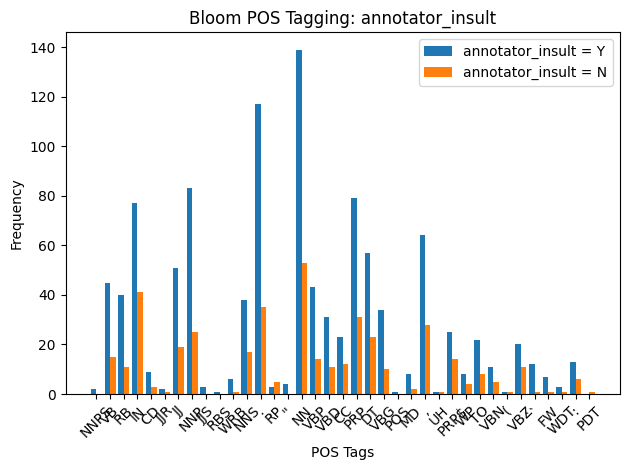

Analyzing Lemma Analysis vs annotator_insult...

=== Bloom Lemma Analysis: annotator_insult ===
Total Lemmas (Y): 1083
Total Lemmas (N): 411

Top Lemmas (Y):
?: 112 (10.34%)
,: 64 (5.91%)
you: 34 (3.14%)
*: 27 (2.49%)
the: 21 (1.94%)
I: 21 (1.94%)
to: 18 (1.66%)
a: 16 (1.48%)
and: 14 (1.29%)
``: 12 (1.11%)

Top Lemmas (N):
?: 34 (8.27%)
,: 28 (6.81%)
a: 10 (2.43%)
and: 10 (2.43%)
of: 9 (2.19%)
fucking: 8 (1.95%)
I: 7 (1.70%)
to: 6 (1.46%)
the: 6 (1.46%)
get: 6 (1.46%)


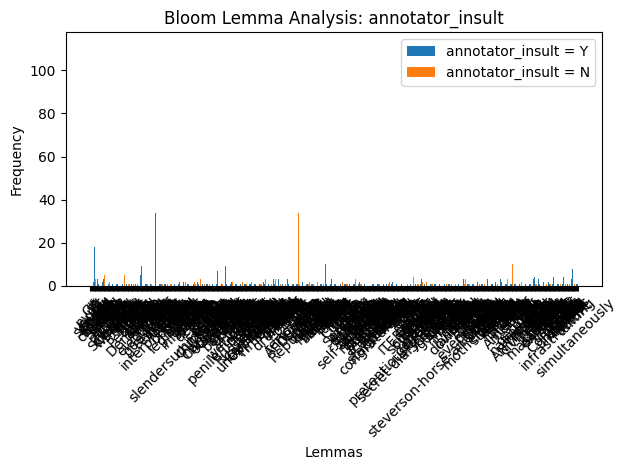

Analyzing NER Analysis vs annotator_insult...

=== Bloom NER Analysis: annotator_insult ===
Total NER Labels (Y): 48
Total NER Labels (N): 11

Top NER Labels (Y):
PERSON: 18 (37.50%)
ORG: 6 (12.50%)
GPE: 6 (12.50%)
CARDINAL: 5 (10.42%)
NORP: 5 (10.42%)
DATE: 2 (4.17%)
LAW: 2 (4.17%)
LOC: 1 (2.08%)
ORDINAL: 1 (2.08%)
WORK_OF_ART: 1 (2.08%)

Top NER Labels (N):
PERSON: 5 (45.45%)
DATE: 3 (27.27%)
GPE: 1 (9.09%)
ORG: 1 (9.09%)
CARDINAL: 1 (9.09%)


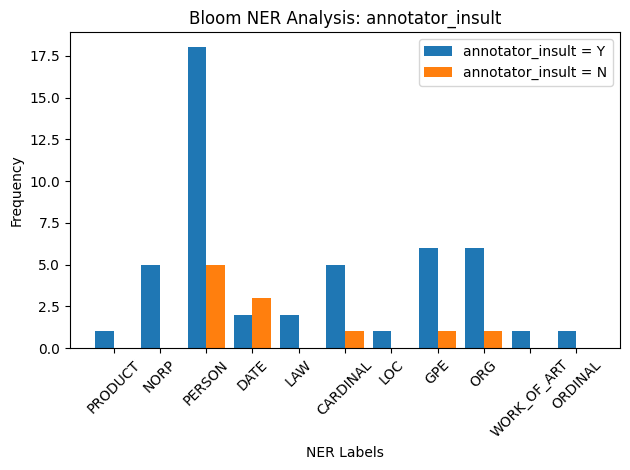

Analyzing POS Tagging vs annotator_threat...

=== Bloom POS Tagging: annotator_threat ===
Total POS tags (Y): 432
Total POS tags (N): 1062

Top POS Tags (Y):
.: 56 (12.96%)
NN: 48 (11.11%)
PRP: 37 (8.56%)
NNP: 35 (8.10%)
,: 32 (7.41%)
IN: 30 (6.94%)
VBP: 23 (5.32%)
JJ: 22 (5.09%)
VB: 20 (4.63%)
DT: 19 (4.40%)

Top POS Tags (N):
NN: 144 (13.56%)
.: 96 (9.04%)
IN: 88 (8.29%)
NNP: 73 (6.87%)
PRP: 73 (6.87%)
DT: 61 (5.74%)
,: 60 (5.65%)
JJ: 48 (4.52%)
RB: 42 (3.95%)
NNS: 42 (3.95%)


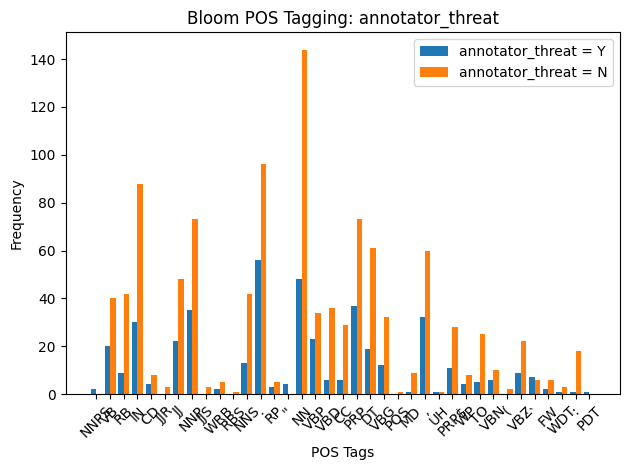

Analyzing Lemma Analysis vs annotator_threat...

=== Bloom Lemma Analysis: annotator_threat ===
Total Lemmas (Y): 432
Total Lemmas (N): 1062

Top Lemmas (Y):
?: 54 (12.50%)
,: 32 (7.41%)
you: 21 (4.86%)
*: 20 (4.63%)
I: 10 (2.31%)
``: 7 (1.62%)
the: 7 (1.62%)
f: 7 (1.62%)
a: 7 (1.62%)
all: 5 (1.16%)

Top Lemmas (N):
?: 92 (8.66%)
,: 60 (5.65%)
and: 21 (1.98%)
the: 20 (1.88%)
to: 19 (1.79%)
a: 19 (1.79%)
you: 19 (1.79%)
I: 18 (1.69%)
:: 15 (1.41%)
fucking: 14 (1.32%)


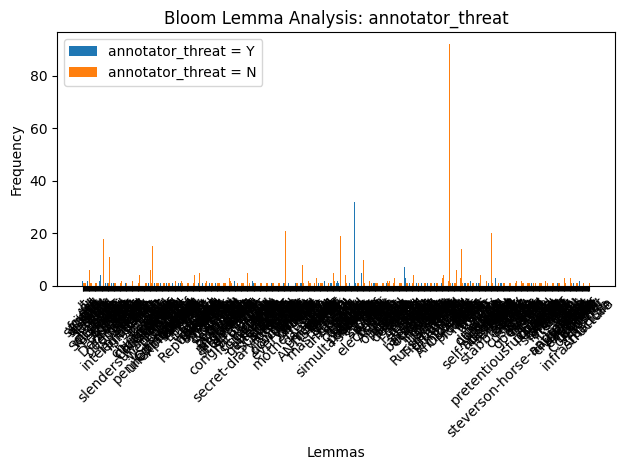

Analyzing NER Analysis vs annotator_threat...

=== Bloom NER Analysis: annotator_threat ===
Total NER Labels (Y): 14
Total NER Labels (N): 45

Top NER Labels (Y):
PERSON: 6 (42.86%)
NORP: 3 (21.43%)
LAW: 2 (14.29%)
GPE: 2 (14.29%)
CARDINAL: 1 (7.14%)

Top NER Labels (N):
PERSON: 17 (37.78%)
ORG: 7 (15.56%)
DATE: 5 (11.11%)
CARDINAL: 5 (11.11%)
GPE: 5 (11.11%)
NORP: 2 (4.44%)
LOC: 1 (2.22%)
ORDINAL: 1 (2.22%)
WORK_OF_ART: 1 (2.22%)
PRODUCT: 1 (2.22%)


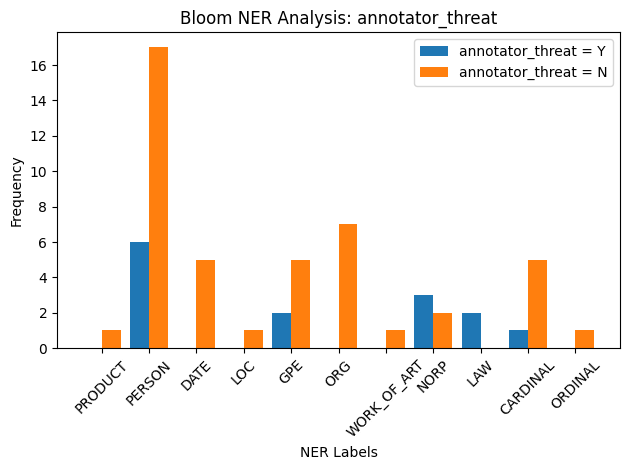

Analyzing POS Tagging vs annotator_identity_attack...

=== Bloom POS Tagging: annotator_identity_attack ===
Total POS tags (Y): 716
Total POS tags (N): 778

Top POS Tags (Y):
NN: 93 (12.99%)
.: 90 (12.57%)
NNP: 59 (8.24%)
,: 48 (6.70%)
IN: 46 (6.42%)
PRP: 46 (6.42%)
DT: 41 (5.73%)
JJ: 38 (5.31%)
VB: 33 (4.61%)
VBP: 28 (3.91%)

Top POS Tags (N):
NN: 99 (12.72%)
IN: 72 (9.25%)
PRP: 64 (8.23%)
.: 62 (7.97%)
NNP: 49 (6.30%)
,: 44 (5.66%)
DT: 39 (5.01%)
NNS: 34 (4.37%)
JJ: 32 (4.11%)
VBP: 29 (3.73%)


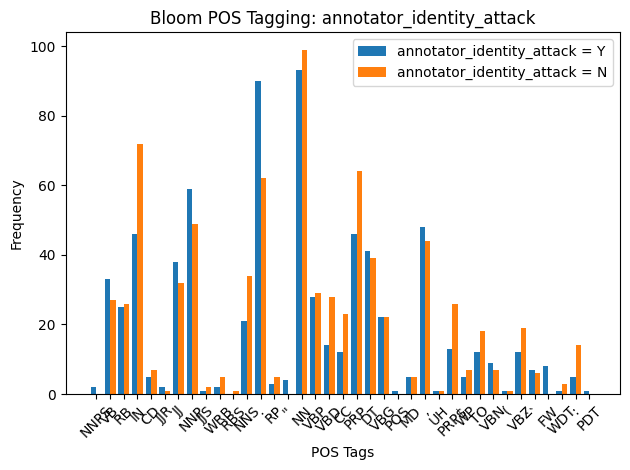

Analyzing Lemma Analysis vs annotator_identity_attack...

=== Bloom Lemma Analysis: annotator_identity_attack ===
Total Lemmas (Y): 716
Total Lemmas (N): 778

Top Lemmas (Y):
?: 86 (12.01%)
,: 48 (6.70%)
*: 23 (3.21%)
you: 22 (3.07%)
I: 13 (1.82%)
a: 12 (1.68%)
the: 11 (1.54%)
to: 9 (1.26%)
shit: 8 (1.12%)
f: 7 (0.98%)

Top Lemmas (N):
?: 60 (7.71%)
,: 44 (5.66%)
and: 19 (2.44%)
you: 18 (2.31%)
the: 16 (2.06%)
I: 15 (1.93%)
to: 15 (1.93%)
a: 14 (1.80%)
fucking: 13 (1.67%)
:: 12 (1.54%)


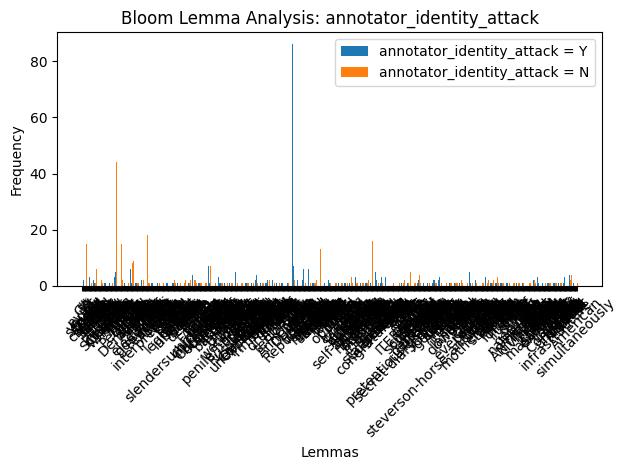

Analyzing NER Analysis vs annotator_identity_attack...

=== Bloom NER Analysis: annotator_identity_attack ===
Total NER Labels (Y): 33
Total NER Labels (N): 26

Top NER Labels (Y):
PERSON: 12 (36.36%)
ORG: 5 (15.15%)
NORP: 4 (12.12%)
CARDINAL: 3 (9.09%)
GPE: 3 (9.09%)
LAW: 2 (6.06%)
LOC: 1 (3.03%)
DATE: 1 (3.03%)
ORDINAL: 1 (3.03%)
WORK_OF_ART: 1 (3.03%)

Top NER Labels (N):
PERSON: 11 (42.31%)
DATE: 4 (15.38%)
GPE: 4 (15.38%)
CARDINAL: 3 (11.54%)
ORG: 2 (7.69%)
NORP: 1 (3.85%)
PRODUCT: 1 (3.85%)


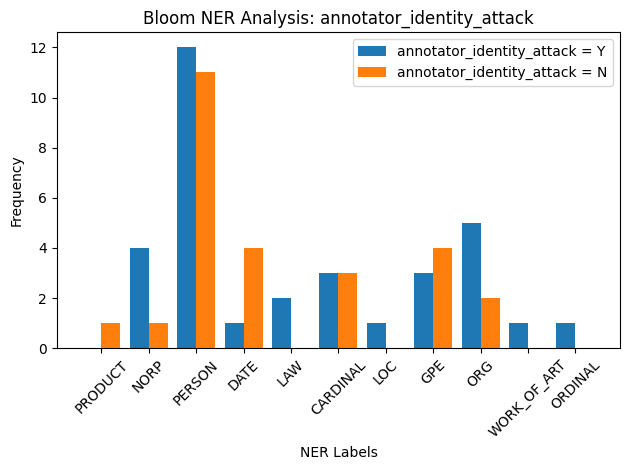


=== Analysis for Model: Llama-2 ===

Analyzing POS Tagging vs annotator_insult...

=== Llama-2 POS Tagging: annotator_insult ===
Total POS tags (Y): 933
Total POS tags (N): 541

Top POS Tags (Y):
NN: 126 (13.50%)
.: 88 (9.43%)
PRP: 70 (7.50%)
NNP: 68 (7.29%)
IN: 67 (7.18%)
DT: 59 (6.32%)
JJ: 58 (6.22%)
,: 49 (5.25%)
VBP: 36 (3.86%)
VB: 30 (3.22%)

Top POS Tags (N):
NN: 78 (14.42%)
.: 47 (8.69%)
IN: 46 (8.50%)
PRP: 42 (7.76%)
DT: 39 (7.21%)
NNP: 36 (6.65%)
JJ: 30 (5.55%)
,: 30 (5.55%)
VBZ: 17 (3.14%)
RB: 16 (2.96%)


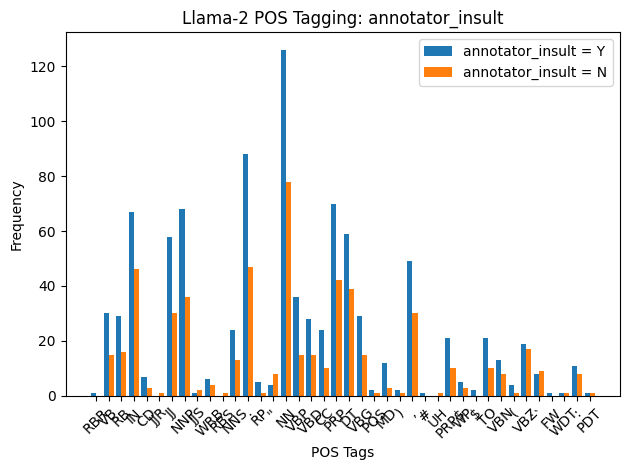

Analyzing Lemma Analysis vs annotator_insult...

=== Llama-2 Lemma Analysis: annotator_insult ===
Total Lemmas (Y): 933
Total Lemmas (N): 541

Top Lemmas (Y):
?: 84 (9.00%)
,: 49 (5.25%)
a: 24 (2.57%)
you: 21 (2.25%)
to: 19 (2.04%)
and: 18 (1.93%)
the: 18 (1.93%)
*: 17 (1.82%)
I: 16 (1.71%)
of: 14 (1.50%)

Top Lemmas (N):
?: 46 (8.50%)
,: 30 (5.55%)
a: 17 (3.14%)
the: 13 (2.40%)
I: 12 (2.22%)
fucking: 11 (2.03%)
of: 10 (1.85%)
``: 9 (1.66%)
you: 9 (1.66%)
is: 9 (1.66%)


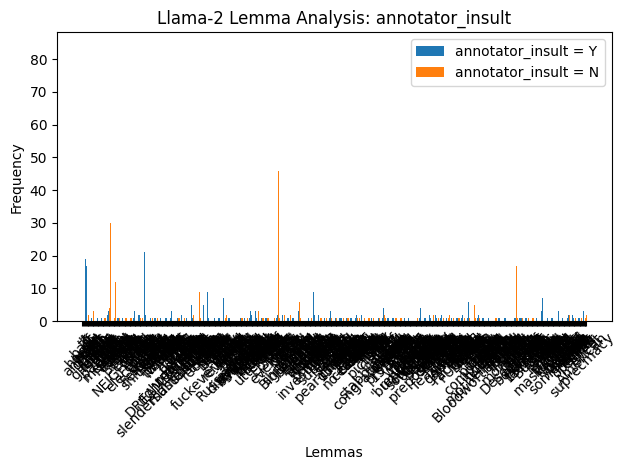

Analyzing NER Analysis vs annotator_insult...

=== Llama-2 NER Analysis: annotator_insult ===
Total NER Labels (Y): 36
Total NER Labels (N): 21

Top NER Labels (Y):
PERSON: 12 (33.33%)
ORG: 8 (22.22%)
ORDINAL: 4 (11.11%)
GPE: 3 (8.33%)
NORP: 2 (5.56%)
CARDINAL: 2 (5.56%)
TIME: 2 (5.56%)
FAC: 1 (2.78%)
WORK_OF_ART: 1 (2.78%)
DATE: 1 (2.78%)

Top NER Labels (N):
PERSON: 7 (33.33%)
DATE: 4 (19.05%)
WORK_OF_ART: 2 (9.52%)
CARDINAL: 2 (9.52%)
NORP: 2 (9.52%)
GPE: 2 (9.52%)
ORG: 1 (4.76%)
PRODUCT: 1 (4.76%)


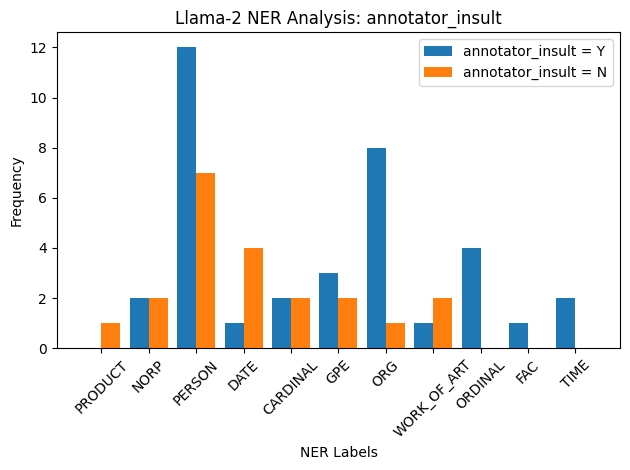

Analyzing POS Tagging vs annotator_threat...

=== Llama-2 POS Tagging: annotator_threat ===
Total POS tags (Y): 285
Total POS tags (N): 1189

Top POS Tags (Y):
NN: 39 (13.68%)
.: 30 (10.53%)
NNP: 26 (9.12%)
IN: 21 (7.37%)
PRP: 20 (7.02%)
DT: 20 (7.02%)
JJ: 17 (5.96%)
,: 14 (4.91%)
VBD: 12 (4.21%)
NNS: 10 (3.51%)

Top POS Tags (N):
NN: 165 (13.88%)
.: 105 (8.83%)
IN: 92 (7.74%)
PRP: 92 (7.74%)
DT: 78 (6.56%)
NNP: 78 (6.56%)
JJ: 71 (5.97%)
,: 65 (5.47%)
VBP: 45 (3.78%)
VB: 38 (3.20%)


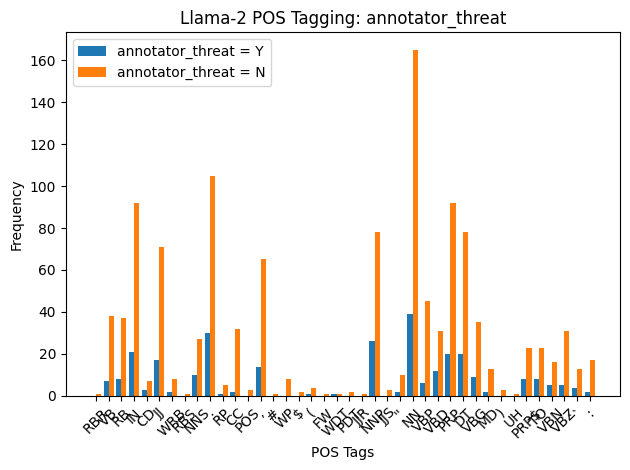

Analyzing Lemma Analysis vs annotator_threat...

=== Llama-2 Lemma Analysis: annotator_threat ===
Total Lemmas (Y): 285
Total Lemmas (N): 1189

Top Lemmas (Y):
?: 30 (10.53%)
,: 14 (4.91%)
the: 9 (3.16%)
you: 6 (2.11%)
to: 6 (2.11%)
a: 5 (1.75%)
*: 5 (1.75%)
``: 4 (1.40%)
on: 4 (1.40%)
I: 4 (1.40%)

Top Lemmas (N):
?: 100 (8.41%)
,: 65 (5.47%)
a: 36 (3.03%)
you: 24 (2.02%)
I: 24 (2.02%)
the: 22 (1.85%)
and: 21 (1.77%)
of: 21 (1.77%)
to: 21 (1.77%)
fucking: 17 (1.43%)


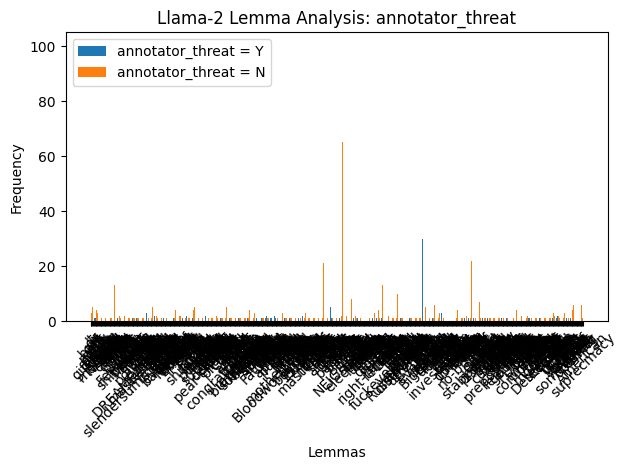

Analyzing NER Analysis vs annotator_threat...

=== Llama-2 NER Analysis: annotator_threat ===
Total NER Labels (Y): 16
Total NER Labels (N): 41

Top NER Labels (Y):
PERSON: 4 (25.00%)
DATE: 3 (18.75%)
CARDINAL: 2 (12.50%)
ORDINAL: 2 (12.50%)
WORK_OF_ART: 1 (6.25%)
GPE: 1 (6.25%)
ORG: 1 (6.25%)
PRODUCT: 1 (6.25%)
NORP: 1 (6.25%)

Top NER Labels (N):
PERSON: 15 (36.59%)
ORG: 8 (19.51%)
GPE: 4 (9.76%)
NORP: 3 (7.32%)
CARDINAL: 2 (4.88%)
TIME: 2 (4.88%)
ORDINAL: 2 (4.88%)
WORK_OF_ART: 2 (4.88%)
DATE: 2 (4.88%)
FAC: 1 (2.44%)


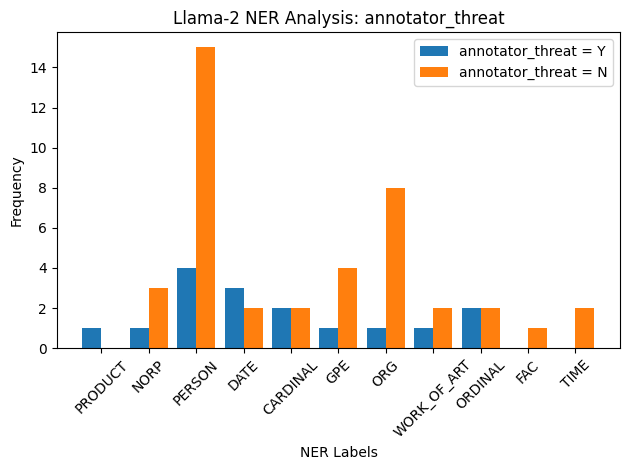

Analyzing POS Tagging vs annotator_identity_attack...

=== Llama-2 POS Tagging: annotator_identity_attack ===
Total POS tags (Y): 359
Total POS tags (N): 1115

Top POS Tags (Y):
NN: 44 (12.26%)
.: 42 (11.70%)
PRP: 29 (8.08%)
IN: 25 (6.96%)
JJ: 22 (6.13%)
NNP: 22 (6.13%)
DT: 21 (5.85%)
VBP: 19 (5.29%)
,: 18 (5.01%)
VBG: 11 (3.06%)

Top POS Tags (N):
NN: 160 (14.35%)
.: 93 (8.34%)
IN: 88 (7.89%)
PRP: 83 (7.44%)
NNP: 82 (7.35%)
DT: 77 (6.91%)
JJ: 66 (5.92%)
,: 61 (5.47%)
RB: 36 (3.23%)
VB: 35 (3.14%)


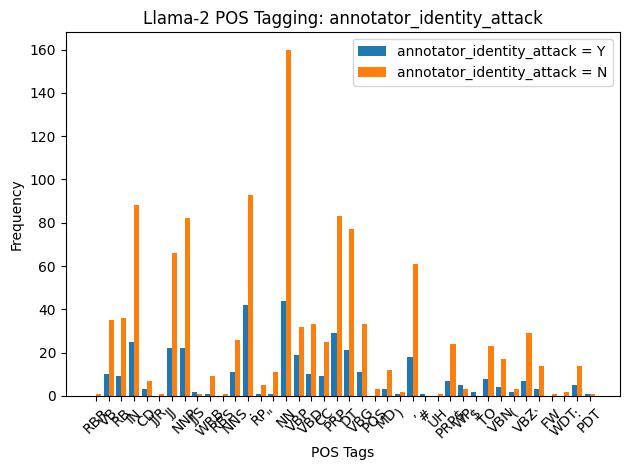

Analyzing Lemma Analysis vs annotator_identity_attack...

=== Llama-2 Lemma Analysis: annotator_identity_attack ===
Total Lemmas (Y): 359
Total Lemmas (N): 1115

Top Lemmas (Y):
?: 40 (11.14%)
,: 18 (5.01%)
you: 12 (3.34%)
and: 8 (2.23%)
to: 8 (2.23%)
a: 8 (2.23%)
the: 7 (1.95%)
of: 6 (1.67%)
I: 6 (1.67%)
are: 5 (1.39%)

Top Lemmas (N):
?: 90 (8.07%)
,: 61 (5.47%)
a: 33 (2.96%)
the: 24 (2.15%)
I: 22 (1.97%)
to: 19 (1.70%)
you: 18 (1.61%)
of: 18 (1.61%)
fucking: 17 (1.52%)
*: 16 (1.43%)


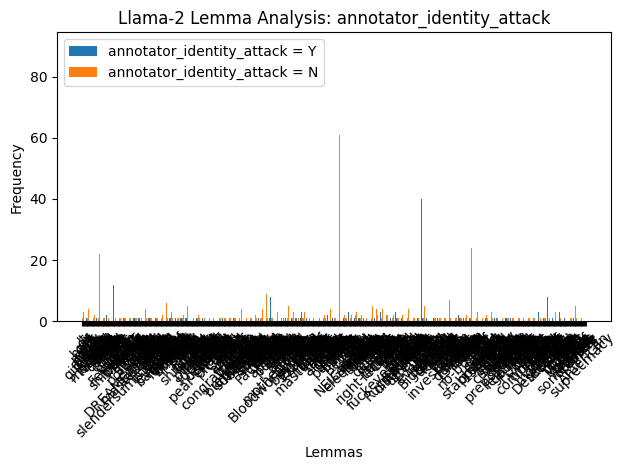

Analyzing NER Analysis vs annotator_identity_attack...

=== Llama-2 NER Analysis: annotator_identity_attack ===
Total NER Labels (Y): 16
Total NER Labels (N): 41

Top NER Labels (Y):
PERSON: 4 (25.00%)
ORDINAL: 3 (18.75%)
GPE: 2 (12.50%)
ORG: 2 (12.50%)
TIME: 2 (12.50%)
WORK_OF_ART: 1 (6.25%)
NORP: 1 (6.25%)
DATE: 1 (6.25%)

Top NER Labels (N):
PERSON: 15 (36.59%)
ORG: 7 (17.07%)
DATE: 4 (9.76%)
CARDINAL: 4 (9.76%)
NORP: 3 (7.32%)
GPE: 3 (7.32%)
WORK_OF_ART: 2 (4.88%)
FAC: 1 (2.44%)
ORDINAL: 1 (2.44%)
PRODUCT: 1 (2.44%)


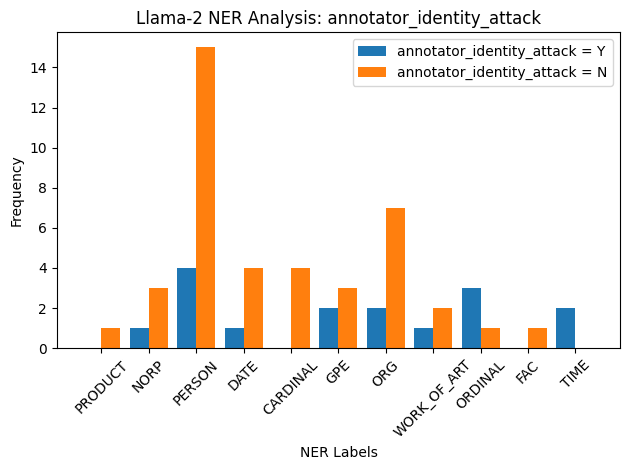


=== Analysis for Model: Llama-3 ===

Analyzing POS Tagging vs annotator_insult...

=== Llama-3 POS Tagging: annotator_insult ===
Total POS tags (Y): 528
Total POS tags (N): 892

Top POS Tags (Y):
NN: 55 (10.42%)
.: 54 (10.23%)
PRP: 52 (9.85%)
IN: 49 (9.28%)
DT: 33 (6.25%)
,: 31 (5.87%)
JJ: 27 (5.11%)
RB: 26 (4.92%)
VB: 23 (4.36%)
NNS: 21 (3.98%)

Top POS Tags (N):
NN: 110 (12.33%)
PRP: 87 (9.75%)
.: 82 (9.19%)
IN: 78 (8.74%)
DT: 57 (6.39%)
JJ: 48 (5.38%)
,: 46 (5.16%)
RB: 42 (4.71%)
NNP: 42 (4.71%)
VB: 38 (4.26%)


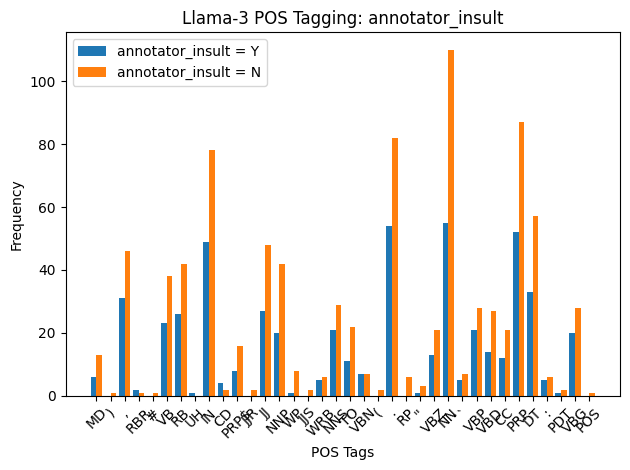

Analyzing Lemma Analysis vs annotator_insult...

=== Llama-3 Lemma Analysis: annotator_insult ===
Total Lemmas (Y): 528
Total Lemmas (N): 892

Top Lemmas (Y):
?: 54 (10.23%)
,: 31 (5.87%)
you: 17 (3.22%)
I: 12 (2.27%)
to: 11 (2.08%)
in: 10 (1.89%)
and: 10 (1.89%)
a: 10 (1.89%)
the: 10 (1.89%)
fucking: 9 (1.70%)

Top Lemmas (N):
?: 81 (9.08%)
,: 46 (5.16%)
I: 27 (3.03%)
you: 21 (2.35%)
to: 20 (2.24%)
a: 19 (2.13%)
of: 17 (1.91%)
the: 17 (1.91%)
and: 16 (1.79%)
*: 9 (1.01%)


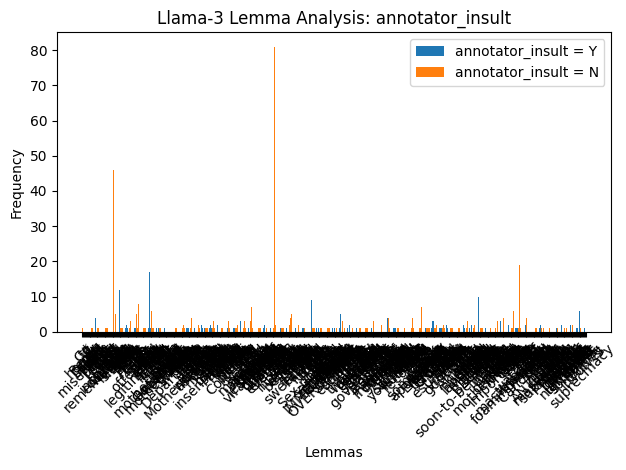

Analyzing NER Analysis vs annotator_insult...

=== Llama-3 NER Analysis: annotator_insult ===
Total NER Labels (Y): 16
Total NER Labels (N): 26

Top NER Labels (Y):
PERSON: 6 (37.50%)
ORG: 5 (31.25%)
CARDINAL: 2 (12.50%)
DATE: 2 (12.50%)
GPE: 1 (6.25%)

Top NER Labels (N):
PERSON: 11 (42.31%)
ORG: 6 (23.08%)
CARDINAL: 3 (11.54%)
NORP: 2 (7.69%)
GPE: 1 (3.85%)
ORDINAL: 1 (3.85%)
TIME: 1 (3.85%)
DATE: 1 (3.85%)


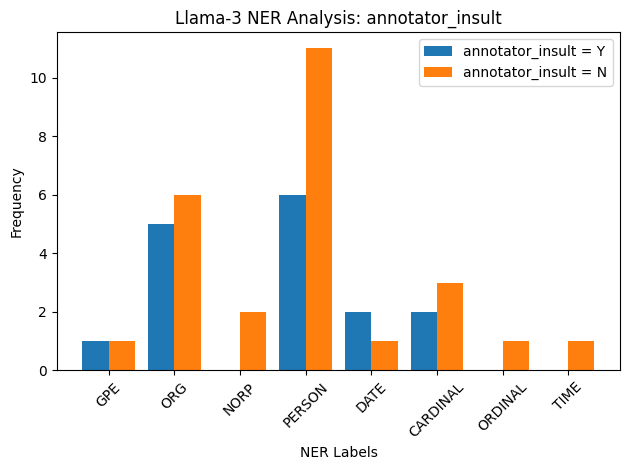

Analyzing POS Tagging vs annotator_threat...

=== Llama-3 POS Tagging: annotator_threat ===
Total POS tags (Y): 365
Total POS tags (N): 1055

Top POS Tags (Y):
PRP: 40 (10.96%)
IN: 34 (9.32%)
NN: 34 (9.32%)
.: 31 (8.49%)
NNP: 24 (6.58%)
VB: 20 (5.48%)
,: 20 (5.48%)
DT: 19 (5.21%)
RB: 19 (5.21%)
VBP: 15 (4.11%)

Top POS Tags (N):
NN: 131 (12.42%)
.: 105 (9.95%)
PRP: 99 (9.38%)
IN: 93 (8.82%)
DT: 71 (6.73%)
JJ: 63 (5.97%)
,: 57 (5.40%)
RB: 49 (4.64%)
VB: 41 (3.89%)
NNP: 38 (3.60%)


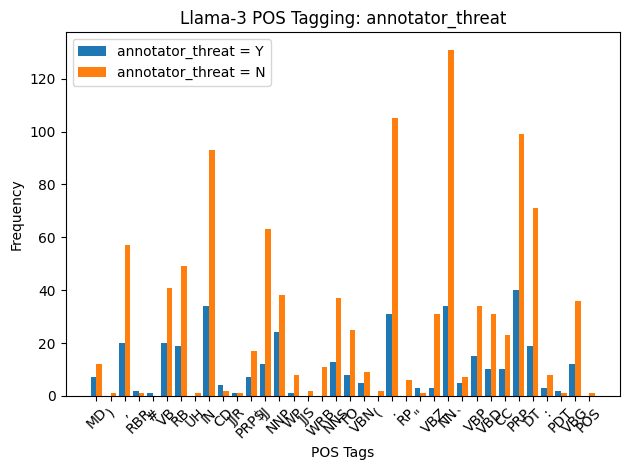

Analyzing Lemma Analysis vs annotator_threat...

=== Llama-3 Lemma Analysis: annotator_threat ===
Total Lemmas (Y): 365
Total Lemmas (N): 1055

Top Lemmas (Y):
?: 31 (8.49%)
,: 20 (5.48%)
I: 17 (4.66%)
you: 14 (3.84%)
a: 9 (2.47%)
to: 7 (1.92%)
and: 7 (1.92%)
``: 5 (1.37%)
of: 5 (1.37%)
the: 5 (1.37%)

Top Lemmas (N):
?: 104 (9.86%)
,: 57 (5.40%)
to: 24 (2.27%)
you: 24 (2.27%)
I: 22 (2.09%)
the: 22 (2.09%)
a: 20 (1.90%)
and: 19 (1.80%)
of: 18 (1.71%)
fucking: 15 (1.42%)


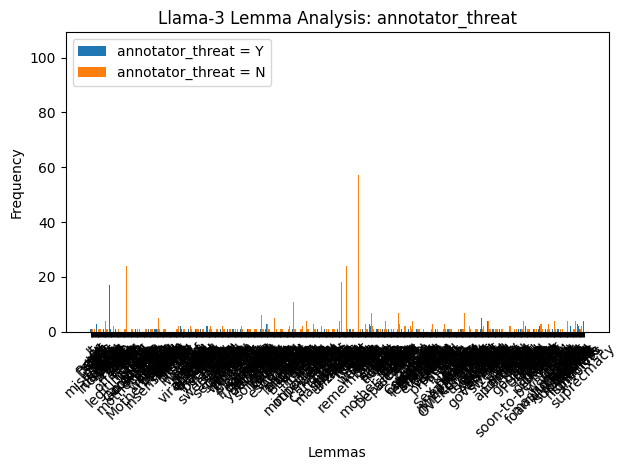

Analyzing NER Analysis vs annotator_threat...

=== Llama-3 NER Analysis: annotator_threat ===
Total NER Labels (Y): 12
Total NER Labels (N): 30

Top NER Labels (Y):
PERSON: 5 (41.67%)
ORG: 3 (25.00%)
CARDINAL: 3 (25.00%)
DATE: 1 (8.33%)

Top NER Labels (N):
PERSON: 12 (40.00%)
ORG: 8 (26.67%)
GPE: 2 (6.67%)
NORP: 2 (6.67%)
CARDINAL: 2 (6.67%)
DATE: 2 (6.67%)
ORDINAL: 1 (3.33%)
TIME: 1 (3.33%)


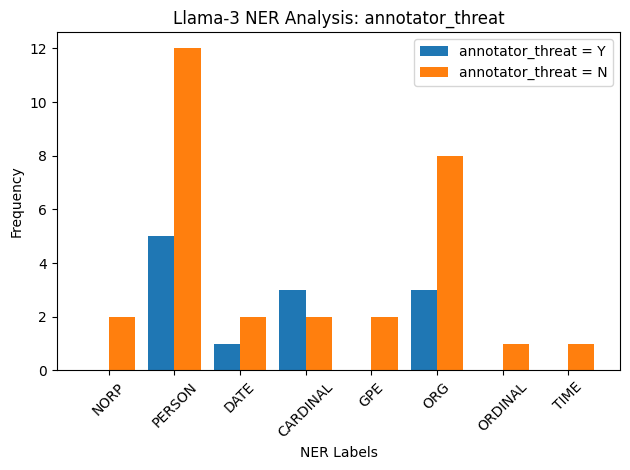

Analyzing POS Tagging vs annotator_identity_attack...

=== Llama-3 POS Tagging: annotator_identity_attack ===
Total POS tags (Y): 785
Total POS tags (N): 635

Top POS Tags (Y):
.: 98 (12.48%)
PRP: 86 (10.96%)
NN: 84 (10.70%)
IN: 66 (8.41%)
,: 48 (6.11%)
VB: 41 (5.22%)
DT: 41 (5.22%)
JJ: 36 (4.59%)
RB: 35 (4.46%)
VBP: 34 (4.33%)

Top POS Tags (N):
NN: 81 (12.76%)
IN: 61 (9.61%)
PRP: 53 (8.35%)
DT: 49 (7.72%)
JJ: 39 (6.14%)
.: 38 (5.98%)
NNP: 35 (5.51%)
RB: 33 (5.20%)
,: 29 (4.57%)
VBD: 22 (3.46%)


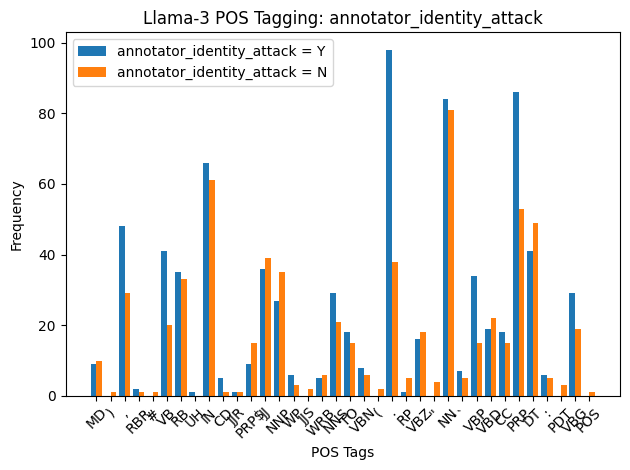

Analyzing Lemma Analysis vs annotator_identity_attack...

=== Llama-3 Lemma Analysis: annotator_identity_attack ===
Total Lemmas (Y): 785
Total Lemmas (N): 635

Top Lemmas (Y):
?: 98 (12.48%)
,: 48 (6.11%)
you: 26 (3.31%)
I: 18 (2.29%)
to: 16 (2.04%)
and: 14 (1.78%)
a: 13 (1.66%)
of: 10 (1.27%)
the: 10 (1.27%)
fucking: 9 (1.15%)

Top Lemmas (N):
?: 37 (5.83%)
,: 29 (4.57%)
I: 21 (3.31%)
the: 17 (2.68%)
a: 16 (2.52%)
to: 15 (2.36%)
of: 13 (2.05%)
and: 12 (1.89%)
you: 12 (1.89%)
is: 7 (1.10%)


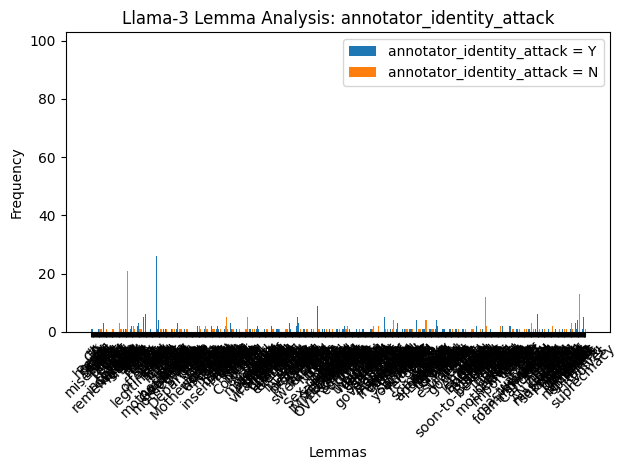

Analyzing NER Analysis vs annotator_identity_attack...

=== Llama-3 NER Analysis: annotator_identity_attack ===
Total NER Labels (Y): 21
Total NER Labels (N): 21

Top NER Labels (Y):
PERSON: 9 (42.86%)
ORG: 5 (23.81%)
CARDINAL: 3 (14.29%)
DATE: 2 (9.52%)
NORP: 1 (4.76%)
ORDINAL: 1 (4.76%)

Top NER Labels (N):
PERSON: 8 (38.10%)
ORG: 6 (28.57%)
GPE: 2 (9.52%)
CARDINAL: 2 (9.52%)
NORP: 1 (4.76%)
TIME: 1 (4.76%)
DATE: 1 (4.76%)


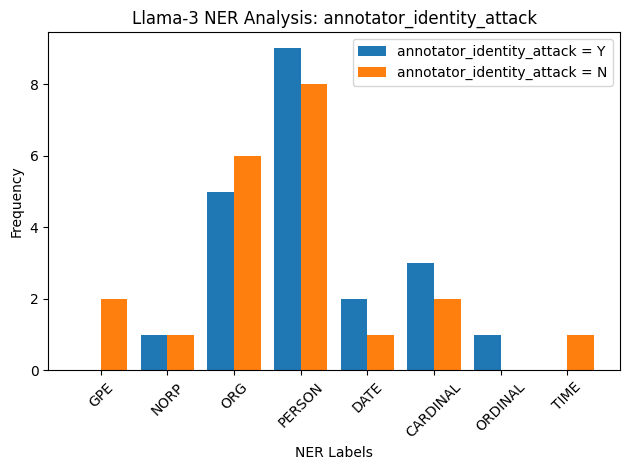

In [16]:

annotations = ["annotator_insult", "annotator_threat", "annotator_identity_attack"]
features = [
    ("POS Tagging", analyze_pos_tags, "prompt_pos_tags"),
    ("Lemma Analysis", analyze_lemmas, "prompt_lemmas"),
    ("NER Analysis", analyze_ner, "prompt_ner")
]

# Analysis
for model, df in data.items():
    print(f"\n=== Analysis for Model: {model} ===\n")
    for annotation in annotations:
        for feature_name, feature_func, feature_col in features:
            print(f"Analyzing {feature_name} vs {annotation}...")
            if feature_name == "POS Tagging":
                feature_func(df, annotation_col=annotation, pos_col=feature_col, label=f"{model} {feature_name}")
            elif feature_name == "Lemma Analysis":
                feature_func(df, annotation_col=annotation, lemmas_col=feature_col, label=f"{model} {feature_name}")
            elif feature_name == "NER Analysis":
                feature_func(df, annotation_col=annotation, ner_col=feature_col, label=f"{model} {feature_name}")



In [17]:
def add_composite_flag(df, annotation_cols):

    df['annotator_flag'] = df[annotation_cols].apply(lambda row: 'Y' if 'Y' in row.values else 'N', axis=1)
    return df

def analyze_pos_tags_overall(df, pos_col="response_pos_tags", label="POS Tagging Analysis"):

    from collections import Counter
    import matplotlib.pyplot as plt

    df_yes = df[df['annotator_flag'] == 'Y']
    df_no = df[df['annotator_flag'] == 'N']

    # Count POS tags
    yes_pos_counter = Counter()
    for pos_list in df_yes[pos_col].dropna():
        for _, tag in eval(pos_list):  # Convert string to list
            yes_pos_counter[tag] += 1

    no_pos_counter = Counter()
    for pos_list in df_no[pos_col].dropna():
        for _, tag in eval(pos_list):
            no_pos_counter[tag] += 1

    # Totals and percentages
    total_yes = sum(yes_pos_counter.values())
    total_no = sum(no_pos_counter.values())
    yes_percentages = {tag: (count / total_yes) * 100 for tag, count in yes_pos_counter.items()}
    no_percentages = {tag: (count / total_no) * 100 for tag, count in no_pos_counter.items()}

    # Numerical statistics
    print(f"\n=== {label}: Overall ===")
    print(f"Total POS tags (Y): {total_yes}")
    print(f"Total POS tags (N): {total_no}")
    print("\nTop POS Tags (Y):")
    for tag, count in yes_pos_counter.most_common(10):
        print(f"{tag}: {count} ({yes_percentages[tag]:.2f}%)")
    print("\nTop POS Tags (N):")
    for tag, count in no_pos_counter.most_common(10):
        print(f"{tag}: {count} ({no_percentages[tag]:.2f}%)")


    # Visualization
    tags = list(set(yes_pos_counter.keys()).union(no_pos_counter.keys()))
    yes_counts = [yes_pos_counter[tag] for tag in tags]
    no_counts = [no_pos_counter[tag] for tag in tags]

    x = range(len(tags))
    plt.bar([i - 0.2 for i in x], yes_counts, width=0.4, label="Toxic (Y)")
    plt.bar([i + 0.2 for i in x], no_counts, width=0.4, label="Non-Toxic (N)")
    plt.xticks(x, tags, rotation=45)
    plt.title(f"{label}: Overall")
    plt.xlabel("POS Tags")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()


def analyze_lemmas_overall(df, lemmas_col="response_lemmas", label="Lemma Analysis"):

    from collections import Counter
    import matplotlib.pyplot as plt

    df_yes = df[df['annotator_flag'] == 'Y']
    df_no = df[df['annotator_flag'] == 'N']

    # Count Lemmas
    yes_lemmas = Counter()
    for lemma_list in df_yes[lemmas_col].dropna():
        for lemma in eval(lemma_list):  # Convert string to list
            yes_lemmas[lemma] += 1

    no_lemmas = Counter()
    for lemma_list in df_no[lemmas_col].dropna():
        for lemma in eval(lemma_list):
            no_lemmas[lemma] += 1

    # Totals and percentages
    total_yes = sum(yes_lemmas.values())
    total_no = sum(no_lemmas.values())
    yes_percentages = {lemma: (count / total_yes) * 100 for lemma, count in yes_lemmas.items()}
    no_percentages = {lemma: (count / total_no) * 100 for lemma, count in no_lemmas.items()}

    # Numerical statistics
    print(f"\n=== {label}: Overall ===")
    print(f"Total Lemmas (Y): {total_yes}")
    print(f"Total Lemmas (N): {total_no}")
    print("\nTop Lemmas (Y):")
    for lemma, count in yes_lemmas.most_common(10):
        print(f"{lemma}: {count} ({yes_percentages[lemma]:.2f}%)")
    print("\nTop Lemmas (N):")
    for lemma, count in no_lemmas.most_common(10):
        print(f"{lemma}: {count} ({no_percentages[lemma]:.2f}%)")

    # Visualization
    lemmas = list(set(yes_lemmas.keys()).union(no_lemmas.keys()))
    yes_counts = [yes_lemmas[lemma] for lemma in lemmas]
    no_counts = [no_lemmas[lemma] for lemma in lemmas]

    x = range(len(lemmas))
    plt.bar([i - 0.2 for i in x], yes_counts, width=0.4, label="Toxic (Y)")
    plt.bar([i + 0.2 for i in x], no_counts, width=0.4, label="Non-Toxic (N)")
    plt.xticks(x, lemmas, rotation=45)
    plt.title(f"{label}: Overall")
    plt.xlabel("Lemmas")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

def analyze_ner_overall(df, ner_col="response_ner", label="NER Analysis"):

    from collections import Counter
    import matplotlib.pyplot as plt

    df_yes = df[df['annotator_flag'] == 'Y']
    df_no = df[df['annotator_flag'] == 'N']

    # Count NER labels
    yes_ner = Counter()
    for ner_list in df_yes[ner_col].dropna():
        for _, ner_type in eval(ner_list):  # Convert string to list
            yes_ner[ner_type] += 1

    no_ner = Counter()
    for ner_list in df_no[ner_col].dropna():
        for _, ner_type in eval(ner_list):
            no_ner[ner_type] += 1

    # Totals and percentages
    total_yes = sum(yes_ner.values())
    total_no = sum(no_ner.values())
    yes_percentages = {ner: (count / total_yes) * 100 for ner, count in yes_ner.items()}
    no_percentages = {ner: (count / total_no) * 100 for ner, count in no_ner.items()}

    # Numerical statistics
    print(f"\n=== {label}: Overall ===")
    print(f"Total NER Labels (Y): {total_yes}")
    print(f"Total NER Labels (N): {total_no}")
    print("\nTop NER Labels (Y):")
    for ner, count in yes_ner.most_common(10):
        print(f"{ner}: {count} ({yes_percentages[ner]:.2f}%)")
    print("\nTop NER Labels (N):")
    for ner, count in no_ner.most_common(10):
        print(f"{ner}: {count} ({no_percentages[ner]:.2f}%)")

    # Visualization
    ners = list(set(yes_ner.keys()).union(no_ner.keys()))
    yes_counts = [yes_ner[ner] for ner in ners]
    no_counts = [no_ner[ner] for ner in ners]

    x = range(len(ners))
    plt.bar([i - 0.2 for i in x], yes_counts, width=0.4, label="Toxic (Y)")
    plt.bar([i + 0.2 for i in x], no_counts, width=0.4, label="Non-Toxic (N)")
    plt.xticks(x, ners, rotation=45)
    plt.title(f"{label}: Overall")
    plt.xlabel("NER Labels")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()




=== Overall Analysis for Model: Bloom ===


=== Bloom POS Tagging: Overall ===
Total POS tags (Y): 1209
Total POS tags (N): 285

Top POS Tags (Y):
NN: 151 (12.49%)
.: 142 (11.75%)
IN: 92 (7.61%)
NNP: 92 (7.61%)
PRP: 91 (7.53%)
,: 72 (5.96%)
DT: 61 (5.05%)
JJ: 54 (4.47%)
VBP: 51 (4.22%)
VB: 50 (4.14%)

Top POS Tags (N):
NN: 41 (14.39%)
IN: 26 (9.12%)
,: 20 (7.02%)
PRP: 19 (6.67%)
DT: 19 (6.67%)
NNP: 16 (5.61%)
JJ: 16 (5.61%)
NNS: 13 (4.56%)
CC: 11 (3.86%)
RB: 11 (3.86%)


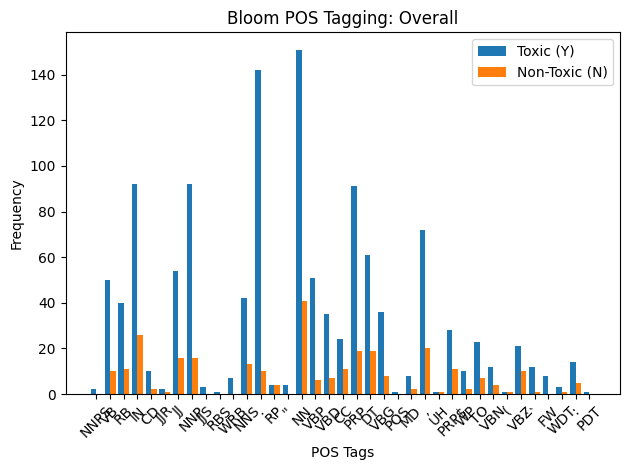


=== Bloom Lemma Analysis: Overall ===
Total Lemmas (Y): 1209
Total Lemmas (N): 285

Top Lemmas (Y):
?: 136 (11.25%)
,: 72 (5.96%)
you: 38 (3.14%)
*: 30 (2.48%)
I: 24 (1.99%)
the: 23 (1.90%)
to: 19 (1.57%)
a: 18 (1.49%)
and: 15 (1.24%)
fuck: 13 (1.08%)

Top Lemmas (N):
,: 20 (7.02%)
?: 10 (3.51%)
and: 9 (3.16%)
a: 8 (2.81%)
fucking: 8 (2.81%)
it: 5 (1.75%)
is: 5 (1.75%)
to: 5 (1.75%)
:: 5 (1.75%)
of: 5 (1.75%)


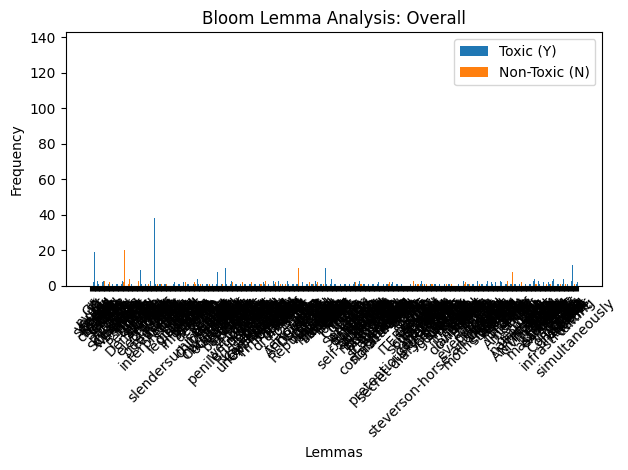


=== Bloom NER Analysis: Overall ===
Total NER Labels (Y): 52
Total NER Labels (N): 7

Top NER Labels (Y):
PERSON: 21 (40.38%)
ORG: 6 (11.54%)
CARDINAL: 6 (11.54%)
GPE: 6 (11.54%)
NORP: 5 (9.62%)
DATE: 2 (3.85%)
LAW: 2 (3.85%)
LOC: 1 (1.92%)
ORDINAL: 1 (1.92%)
WORK_OF_ART: 1 (1.92%)

Top NER Labels (N):
DATE: 3 (42.86%)
PERSON: 2 (28.57%)
GPE: 1 (14.29%)
ORG: 1 (14.29%)


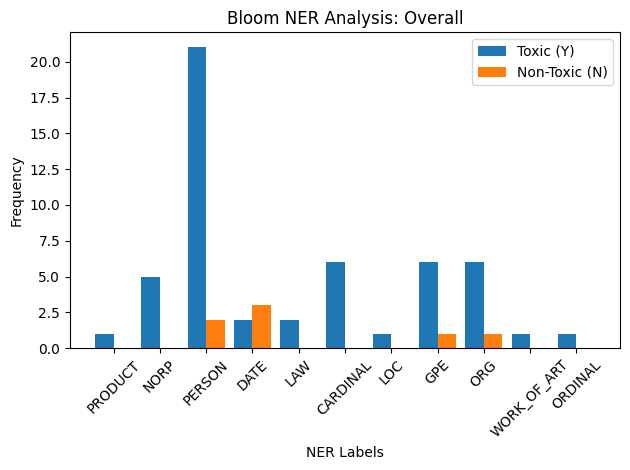


=== Overall Analysis for Model: Llama-2 ===


=== Llama-2 POS Tagging: Overall ===
Total POS tags (Y): 1084
Total POS tags (N): 390

Top POS Tags (Y):
NN: 142 (13.10%)
.: 108 (9.96%)
NNP: 88 (8.12%)
PRP: 83 (7.66%)
IN: 79 (7.29%)
DT: 67 (6.18%)
JJ: 64 (5.90%)
,: 57 (5.26%)
VBP: 40 (3.69%)
VBD: 35 (3.23%)

Top POS Tags (N):
NN: 62 (15.90%)
IN: 34 (8.72%)
DT: 31 (7.95%)
PRP: 29 (7.44%)
.: 27 (6.92%)
JJ: 24 (6.15%)
,: 22 (5.64%)
NNP: 16 (4.10%)
VBZ: 15 (3.85%)
VBG: 14 (3.59%)


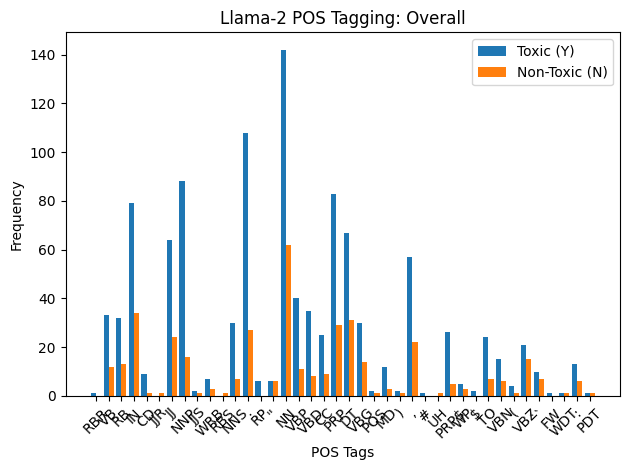


=== Llama-2 Lemma Analysis: Overall ===
Total Lemmas (Y): 1084
Total Lemmas (N): 390

Top Lemmas (Y):
?: 104 (9.59%)
,: 57 (5.26%)
a: 25 (2.31%)
you: 25 (2.31%)
the: 21 (1.94%)
to: 21 (1.94%)
I: 19 (1.75%)
and: 19 (1.75%)
*: 18 (1.66%)
of: 14 (1.29%)

Top Lemmas (N):
?: 26 (6.67%)
,: 22 (5.64%)
a: 16 (4.10%)
fucking: 11 (2.82%)
the: 10 (2.56%)
of: 10 (2.56%)
I: 9 (2.31%)
is: 9 (2.31%)
``: 7 (1.79%)
to: 6 (1.54%)


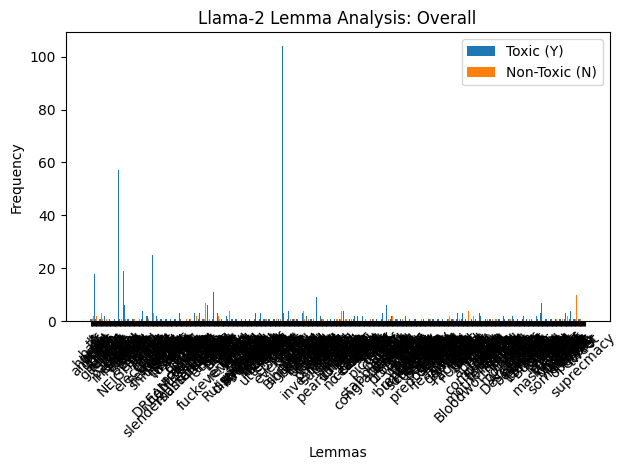


=== Llama-2 NER Analysis: Overall ===
Total NER Labels (Y): 47
Total NER Labels (N): 10

Top NER Labels (Y):
PERSON: 14 (29.79%)
ORG: 8 (17.02%)
DATE: 4 (8.51%)
NORP: 4 (8.51%)
GPE: 4 (8.51%)
ORDINAL: 4 (8.51%)
CARDINAL: 3 (6.38%)
WORK_OF_ART: 2 (4.26%)
TIME: 2 (4.26%)
FAC: 1 (2.13%)

Top NER Labels (N):
PERSON: 5 (50.00%)
WORK_OF_ART: 1 (10.00%)
ORG: 1 (10.00%)
DATE: 1 (10.00%)
GPE: 1 (10.00%)
CARDINAL: 1 (10.00%)


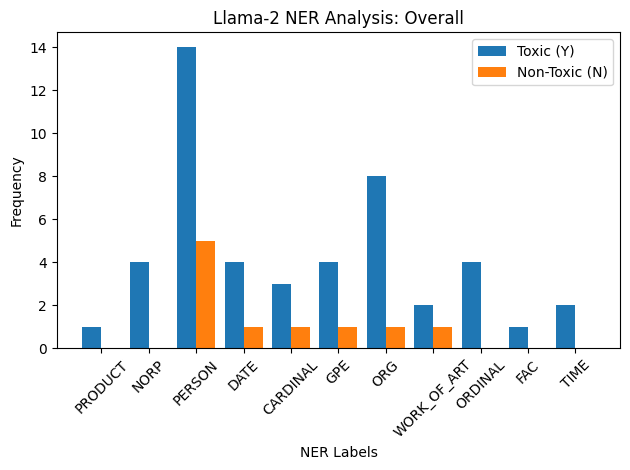


=== Overall Analysis for Model: Llama-3 ===


=== Llama-3 POS Tagging: Overall ===
Total POS tags (Y): 972
Total POS tags (N): 448

Top POS Tags (Y):
.: 109 (11.21%)
PRP: 106 (10.91%)
NN: 103 (10.60%)
IN: 84 (8.64%)
DT: 56 (5.76%)
,: 52 (5.35%)
VB: 46 (4.73%)
JJ: 46 (4.73%)
RB: 46 (4.73%)
NNP: 43 (4.42%)

Top POS Tags (N):
NN: 62 (13.84%)
IN: 43 (9.60%)
DT: 34 (7.59%)
PRP: 33 (7.37%)
JJ: 29 (6.47%)
.: 27 (6.03%)
,: 25 (5.58%)
RB: 22 (4.91%)
NNP: 19 (4.24%)
NNS: 17 (3.79%)


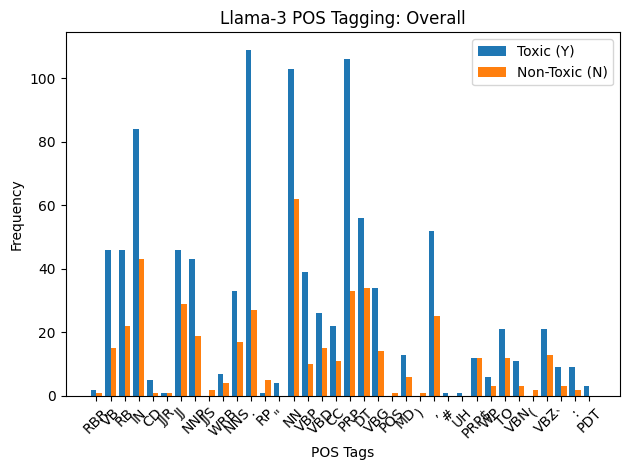


=== Llama-3 Lemma Analysis: Overall ===
Total Lemmas (Y): 972
Total Lemmas (N): 448

Top Lemmas (Y):
?: 109 (11.21%)
,: 52 (5.35%)
you: 31 (3.19%)
I: 28 (2.88%)
to: 19 (1.95%)
a: 18 (1.85%)
the: 17 (1.75%)
and: 16 (1.65%)
fucking: 13 (1.34%)
in: 10 (1.03%)

Top Lemmas (N):
?: 26 (5.80%)
,: 25 (5.58%)
of: 13 (2.90%)
to: 12 (2.68%)
a: 11 (2.46%)
I: 11 (2.46%)
and: 10 (2.23%)
the: 10 (2.23%)
you: 7 (1.56%)
is: 6 (1.34%)


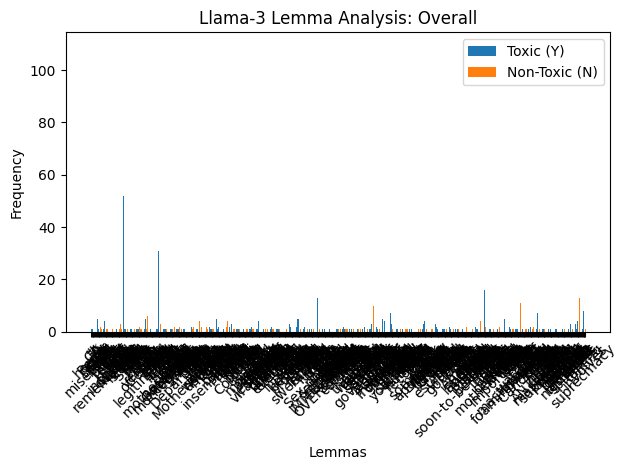


=== Llama-3 NER Analysis: Overall ===
Total NER Labels (Y): 28
Total NER Labels (N): 14

Top NER Labels (Y):
PERSON: 11 (39.29%)
ORG: 8 (28.57%)
CARDINAL: 4 (14.29%)
DATE: 2 (7.14%)
NORP: 1 (3.57%)
ORDINAL: 1 (3.57%)
GPE: 1 (3.57%)

Top NER Labels (N):
PERSON: 6 (42.86%)
ORG: 3 (21.43%)
GPE: 1 (7.14%)
CARDINAL: 1 (7.14%)
NORP: 1 (7.14%)
TIME: 1 (7.14%)
DATE: 1 (7.14%)


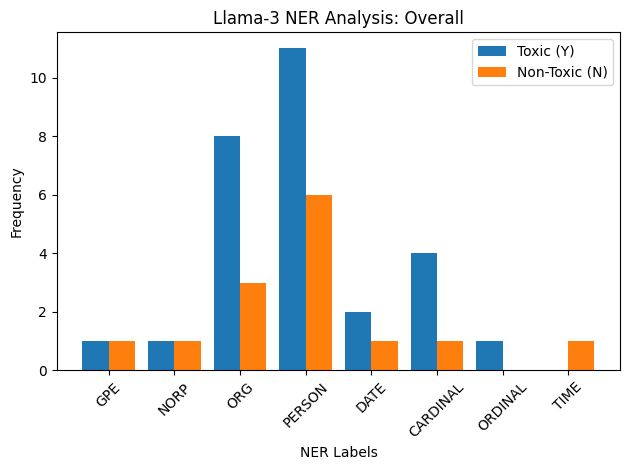

In [19]:
# Composite flag to each model
annotations = ["annotator_insult", "annotator_threat", "annotator_identity_attack"]
for model, df in data.items():
    data[model] = add_composite_flag(df, annotations)

# Overall analysis for each feature
for model, df in data.items():
    print(f"\n=== Overall Analysis for Model: {model} ===\n")
    analyze_pos_tags_overall(df, pos_col="prompt_pos_tags", label=f"{model} POS Tagging")
    analyze_lemmas_overall(df, lemmas_col="prompt_lemmas", label=f"{model} Lemma Analysis")
    analyze_ner_overall(df, ner_col="prompt_ner", label=f"{model} NER Analysis")
